In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
beta = 25   # =(1/0.2)**2
a_star = np.array([-0.3, 0.5])

def biasify(x):
    return np.append(x[:, np.newaxis], np.ones((x.shape[0], 1)), 1)

def oracle(x, a=None, epsilon=0.):
    # x should be N, a should be d, epsilon should be N
    if a is None:
        a = a_star
    x_and_bias = np.append(x[:, np.newaxis], np.ones((x.shape[0], 1)), 1)
    return x_and_bias@a + epsilon  # size N

def smoothen(out, N):
    return np.convolve(out, np.ones(N)/N, mode='valid')

In [3]:
# Prior
alpha = 10
m0 = np.array([-1, -1])
S0 = alpha * np.eye(2)   # Precision, NOT COVARIANCE !!

def update_prior(m, S, x, y):
    x_and_bias = np.append(x[:, np.newaxis], np.ones((x.shape[0], 1)), 1)
    S2 = S + beta * (x_and_bias).T @ x_and_bias
    m2 = np.linalg.inv(S2) @ (S@m + beta * (x_and_bias).T @ y)
    return m2, S2

In [4]:
# Training data
N = 3
x_train = 2 * np.random.rand(N) - 1.  # N random numbers in [-1, 1]
epsilon = 1./np.sqrt(beta) * np.random.randn(N)
y_train = oracle(x_train, epsilon=epsilon)

In [5]:
# OOS data
N2 = 6
x_oos_temp = np.random.rand(N2 // 2) + 1. # N2 random numbers in [1, 2]
x_oos = np.random.rand(N2) - 2. 
x_oos[:N2 // 2] = x_oos_temp
epsilon = 1./np.sqrt(beta) * np.random.randn(N2)
y_oos = oracle(x_oos, epsilon=epsilon)

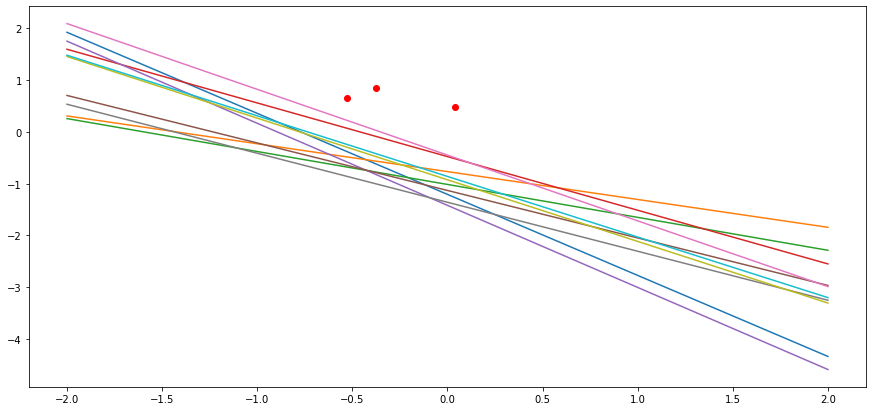

In [6]:
# Samples from prior
x_test = np.linspace(-2, 2, 200)
plt.figure(figsize=(15, 7))
plt.plot(x_train, y_train, 'ro')
for i in range(10):
    w = np.random.multivariate_normal(m0, np.linalg.inv(S0))
    plt.plot(x_test, oracle(x_test, w))
plt.show()

In [7]:
m, S = update_prior(m0, S0, x_train, y_train)

In [8]:
# Posterior predictive
def posterior_predictive(x, m, S):
    # returns mean and variance of normal
    x_and_bias = biasify(x)
    mu = x_and_bias@m
    Sigma = np.diag([1./ beta + x_and_bias[i].T@np.linalg.inv(S)@x_and_bias[i] for i in range(x.shape[0])])
    return mu, Sigma

In [9]:
# Generic quadratic
def generic_quadratic(x, A):
    # can be easily einsum'd
    x_and_bias = np.append(x[:, np.newaxis], np.ones((x.shape[0], 1)), 1)
    return np.array([x_and_bias[i].T@A@x_and_bias[i] for i in range(x.shape[0])])

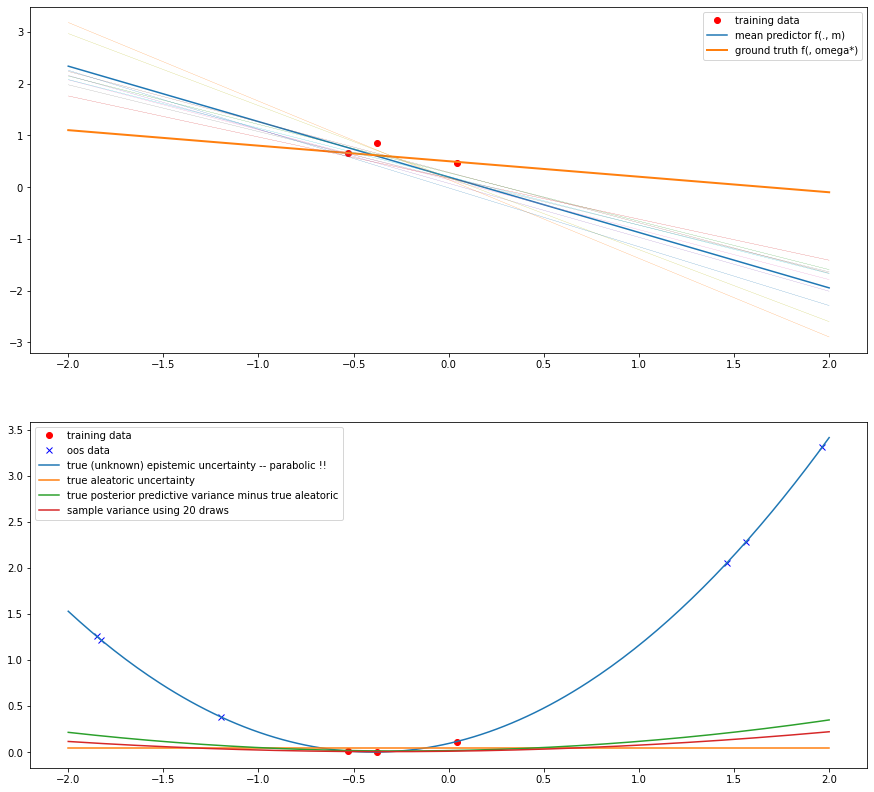

In [10]:
# Samples from posterior
plt.figure(figsize=(15, 14))

plt.subplot(2, 1, 1)
plt.plot(x_train, y_train, 'ro', label='training data')
plt.plot(x_test, oracle(x_test, m), linewidth=1.5, label='mean predictor f(., m)')
plt.plot(x_test, oracle(x_test), linewidth=2, label='ground truth f(, omega*)')
for i in range(10):
    w = np.random.multivariate_normal(m, np.linalg.inv(S))
    plt.plot(x_test, oracle(x_test, w), linewidth=.2)
plt.legend()

sample_variance = np.stack([oracle(x_test, np.random.multivariate_normal(m, np.linalg.inv(S))) for _ in range(20)]).var(0)

plt.subplot(2, 1, 2)
plt.plot(x_train, (oracle(x_train) - oracle(x_train, m)) ** 2, 'ro', label='training data')
plt.plot(x_oos, (oracle(x_oos) - oracle(x_oos, m)) ** 2, 'bx', label='oos data')
plt.plot(x_test, (oracle(x_test) - oracle(x_test, m)) ** 2, label='true (unknown) epistemic uncertainty -- parabolic !!')
# plt.fill_between(x_test, np.zeros(len(x_test)), 1./ beta * np.ones(len(x_test)), alpha=.3, label='aleatoric uncertainty')
plt.plot(x_test, 1./beta * np.ones(len(x_test)), label='true aleatoric uncertainty')
plt.plot(x_test, np.diag(posterior_predictive(x_test, m, S)[1]) - 1./beta, label='true posterior predictive variance minus true aleatoric')
plt.plot(x_test, sample_variance, label='sample variance using 20 draws')
# plt.plot(x_test, generic_quadratic(x_test, np.outer((m - a_star), (m - a_star))), '.', label='calibrated covariance')


plt.legend()

plt.show()

In [11]:
import torch
import torch.nn as nn

m_tensor = torch.tensor(m)

In [12]:
# Parametric re-calibrated posterior N(m, BB^T)
B = torch.randn(2, 2)
B[0, 1] = 0.
B = nn.Parameter(B)
# Q = m + B N(0, 1)

In [13]:
B

Parameter containing:
tensor([[ 0.6089,  0.0000],
        [ 1.9795, -1.9859]], requires_grad=True)

In [14]:
X_train = torch.tensor(biasify(x_train))
X_oos = torch.tensor(biasify(x_oos))
Y_train = torch.tensor(y_train)
Y_oos = torch.tensor(y_oos)
ds = torch.utils.data.TensorDataset(torch.cat([X_train, X_oos]), torch.cat([Y_train, Y_oos]))
#ds = torch.utils.data.TensorDataset(X_oos, Y_oos)

In [15]:
LR = 7e-2
optimizer = torch.optim.SGD([B], lr=LR)

In [16]:
BS = 5
K = 10
dl = torch.utils.data.DataLoader(ds, batch_size=BS)
losses = []
for epoch in range(1000):
    epoch_losses = []
    for batch, (xi, yi) in enumerate(dl):
        optimizer.zero_grad()
        residual = (xi@m_tensor - yi).pow(2)
#         samples = [m_tensor + B@torch.randn(2) for _ in range(K)]
#         estimates = torch.stack([xi@sample for sample in samples])
#         var_estimator = K / (K-1.) * estimates.var(0)
        
        true_var = torch.einsum('ni, ij, nj -> n', xi.double(), (B@B.T).double(), xi.double())  # available for linear models !!
        
        
        loss = nn.MSELoss()(residual - 1./beta, true_var)
        # loss = nn.MSELoss()((xi@(m_tensor - torch.tensor(a_star))).pow(2), true_var)  # CHEAT !!
        loss.backward()
        epoch_losses.append(loss.item())
        optimizer.step()
    losses.append(np.mean(epoch_losses))
        

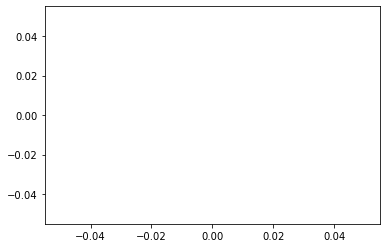

In [17]:
plt.plot(losses[-100:])

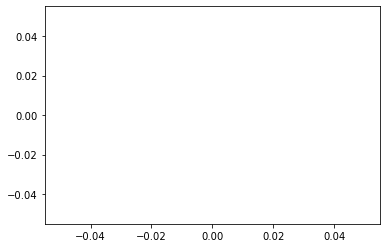

In [18]:
plt.plot(smoothen(losses, N=100))

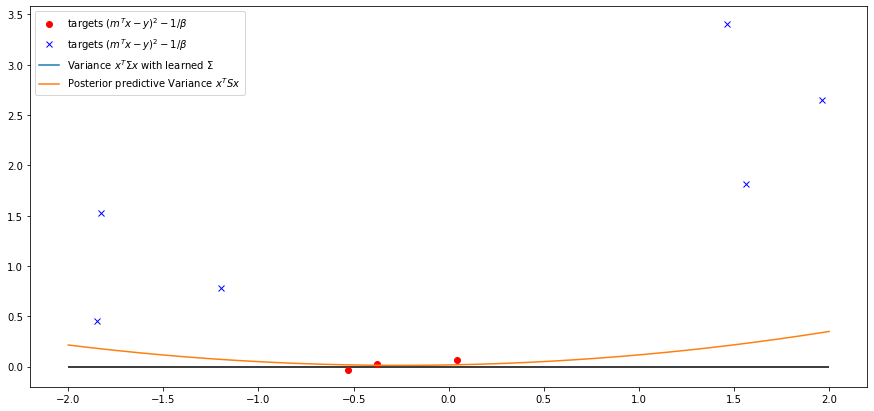

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(x_train, (oracle(x_train, m) - y_train) ** 2 - 1./beta, 'ro', label=r'targets $(m^Tx - y)^2 - 1/\beta$')
plt.plot(x_oos, (oracle(x_oos, m) - y_oos) ** 2 - 1./beta, 'bx', label=r'targets $(m^Tx - y)^2 - 1/\beta$')
plt.plot(x_test, generic_quadratic(x_test, (B@B.T).detach().numpy()), label=r'Variance $x^T \Sigma x$ with learned $\Sigma$')
plt.plot(x_test, generic_quadratic(x_test, np.linalg.inv(S)), label=r'Posterior predictive Variance $x^T S x$')
plt.hlines(0, -2, 2, 'k')
plt.legend()
plt.show()

In [20]:
B@B.T

tensor([[nan, nan],
        [nan, nan]], grad_fn=<MmBackward>)

In [21]:
np.outer(m - a_star, m - a_star)

array([[0.59418187, 0.23555417],
       [0.23555417, 0.09338179]])

<ipython-input-22-f54e508fa306>:38: RuntimeWarning: covariance is not positive-semidefinite.
  w = np.random.multivariate_normal(m, (B@B.T).detach().numpy())
<ipython-input-22-f54e508fa306>:38: RuntimeWarning: covariance is not positive-semidefinite.
  w = np.random.multivariate_normal(m, (B@B.T).detach().numpy())
<ipython-input-22-f54e508fa306>:38: RuntimeWarning: covariance is not positive-semidefinite.
  w = np.random.multivariate_normal(m, (B@B.T).detach().numpy())
<ipython-input-22-f54e508fa306>:38: RuntimeWarning: covariance is not positive-semidefinite.
  w = np.random.multivariate_normal(m, (B@B.T).detach().numpy())
<ipython-input-22-f54e508fa306>:38: RuntimeWarning: covariance is not positive-semidefinite.
  w = np.random.multivariate_normal(m, (B@B.T).detach().numpy())
<ipython-input-22-f54e508fa306>:38: RuntimeWarning: covariance is not positive-semidefinite.
  w = np.random.multivariate_normal(m, (B@B.T).detach().numpy())
<ipython-input-22-f54e508fa306>:38: RuntimeWarning: 

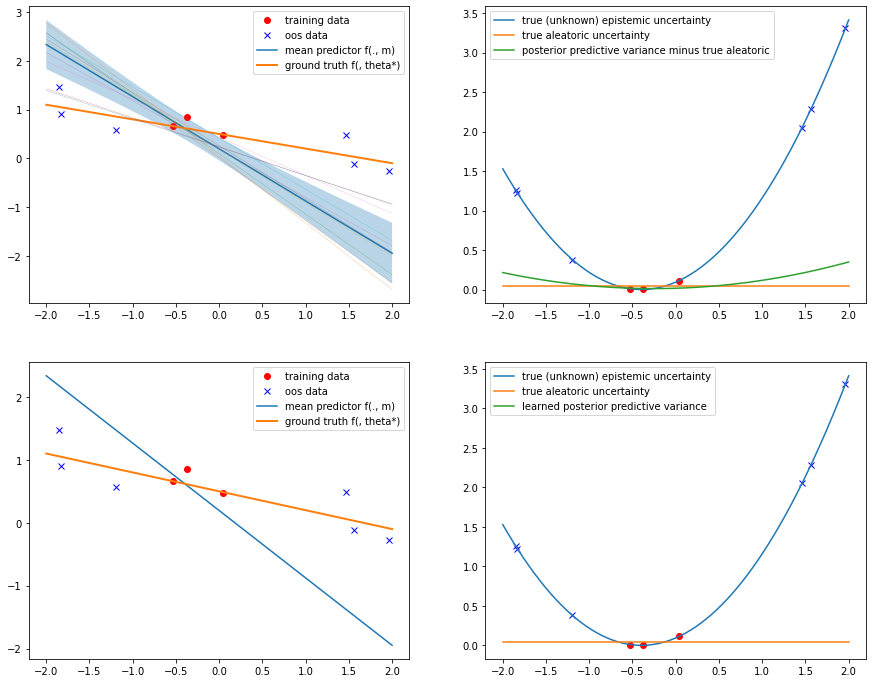

In [22]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.plot(x_train, y_train, 'ro', label='training data')
plt.plot(x_oos, y_oos, 'bx', label='oos data')
plt.plot(x_test, oracle(x_test, m), linewidth=1.5, label='mean predictor f(., m)')
plt.plot(x_test, oracle(x_test), linewidth=2, label='ground truth f(, theta*)')
plt.fill_between(x_test, oracle(x_test, m) - np.sqrt(np.diag(posterior_predictive(x_test, m, S)[1])),
                 oracle(x_test, m) + np.sqrt(np.diag(posterior_predictive(x_test, m, S)[1])),
                 alpha=.3)
for i in range(10):
    w = np.random.multivariate_normal(m, np.linalg.inv(S))
    plt.plot(x_test, oracle(x_test, w), linewidth=.2)
plt.legend()

sample_variance = np.stack([oracle(x_test, np.random.multivariate_normal(m, np.linalg.inv(S))) for _ in range(20)]).var(0)

plt.subplot(2, 2, 2)
plt.plot(x_train, (oracle(x_train) - oracle(x_train, m)) ** 2, 'ro')
plt.plot(x_oos, (oracle(x_oos) - oracle(x_oos, m)) ** 2, 'bx')
plt.plot(x_test, (oracle(x_test) - oracle(x_test, m)) ** 2, label='true (unknown) epistemic uncertainty')
# plt.fill_between(x_test, np.zeros(len(x_test)), 1./ beta * np.ones(len(x_test)), alpha=.3, label='aleatoric uncertainty')
plt.plot(x_test, 1./beta * np.ones(len(x_test)), label='true aleatoric uncertainty')
plt.plot(x_test, np.diag(posterior_predictive(x_test, m, S)[1]) - 1./beta, label='posterior predictive variance minus true aleatoric')
# plt.plot(x_test, sample_variance, label='sample variance using 20 draws')
# plt.plot(x_test, generic_quadratic(x_test, np.outer((m - a_star), (m - a_star))), '.', label='calibrated covariance')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x_train, y_train, 'ro', label='training data')
plt.plot(x_oos, y_oos, 'bx', label='oos data')
plt.plot(x_test, oracle(x_test, m), linewidth=1.5, label='mean predictor f(., m)')
plt.fill_between(x_test, oracle(x_test, m) - np.sqrt(generic_quadratic(x_test, (B@B.T).detach().numpy()) + 1./beta),
                 oracle(x_test, m) + np.sqrt(generic_quadratic(x_test, (B@B.T).detach().numpy()) + 1./beta),
                alpha=.3)
plt.plot(x_test, oracle(x_test), linewidth=2, label='ground truth f(, theta*)')
for i in range(10):
    w = np.random.multivariate_normal(m, (B@B.T).detach().numpy())
    plt.plot(x_test, oracle(x_test, w), linewidth=.2)
plt.legend()

# sample_variance_2 = np.stack([oracle(x_test, (m_tensor + B@torch.randn(2)).detach().numpy()) for _ in range(200)]).var(0)

plt.subplot(2, 2, 4)
plt.plot(x_train, (oracle(x_train) - oracle(x_train, m)) ** 2, 'ro')
plt.plot(x_oos, (oracle(x_oos) - oracle(x_oos, m)) ** 2, 'bx')
plt.plot(x_test, (oracle(x_test) - oracle(x_test, m)) ** 2, label='true (unknown) epistemic uncertainty')
# plt.fill_between(x_test, np.zeros(len(x_test)), 1./ beta * np.ones(len(x_test)), alpha=.3, label='aleatoric uncertainty')
plt.plot(x_test, 1./beta * np.ones(len(x_test)), label='true aleatoric uncertainty')
plt.plot(x_test, generic_quadratic(x_test, (B@B.T).detach().numpy()), label='learned posterior predictive variance')
# plt.plot(x_test, sample_variance_2, label='calibrated sample variance using 20 draws')
# plt.plot(x_test, generic_quadratic(x_test, np.outer((m - a_star), (m - a_star))), '.', label='calibrated covariance')

plt.legend()


plt.show()

In [23]:
np.linalg.norm(np.linalg.inv(S) - np.outer(m - a_star, m - a_star))

0.61665550011374

In [24]:
np.linalg.norm((B@B.T).detach().numpy() - np.outer(m - a_star, m - a_star))

nan